<a href="https://colab.research.google.com/github/ma850419/Fast_UNet/blob/main/Copy_of_csiro_pasture_03jan2026_AAA_use_this_good_one_givmehigh_r2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Training data shape: (1785, 9)

Target value distribution:
              count       mean        std   min      25%      50%      75%  \
target_name                                                                  
Dry_Clover_g  357.0   6.649692  12.117761  0.00   0.0000   1.4235   7.2429   
Dry_Dead_g    357.0  12.044548  12.402007  0.00   3.2000   7.9809  17.6378   
Dry_Green_g   357.0  26.624722  25.401232  0.00   8.8000  20.8000  35.0834   
Dry_Total_g   357.0  45.318097  27.984015  1.04  25.2715  40.3000  57.8800   
GDM_g         357.0  33.274414  24.935822  1.04  16.0261  27.1082  43.6757   

                   max  
target_name             
Dry_Clover_g   71.7865  
Dry_Dead_g     83.8407  
Dry_Green_g   157.9836  
Dry_Total_g   185.7000  
GDM_g         157.9836  


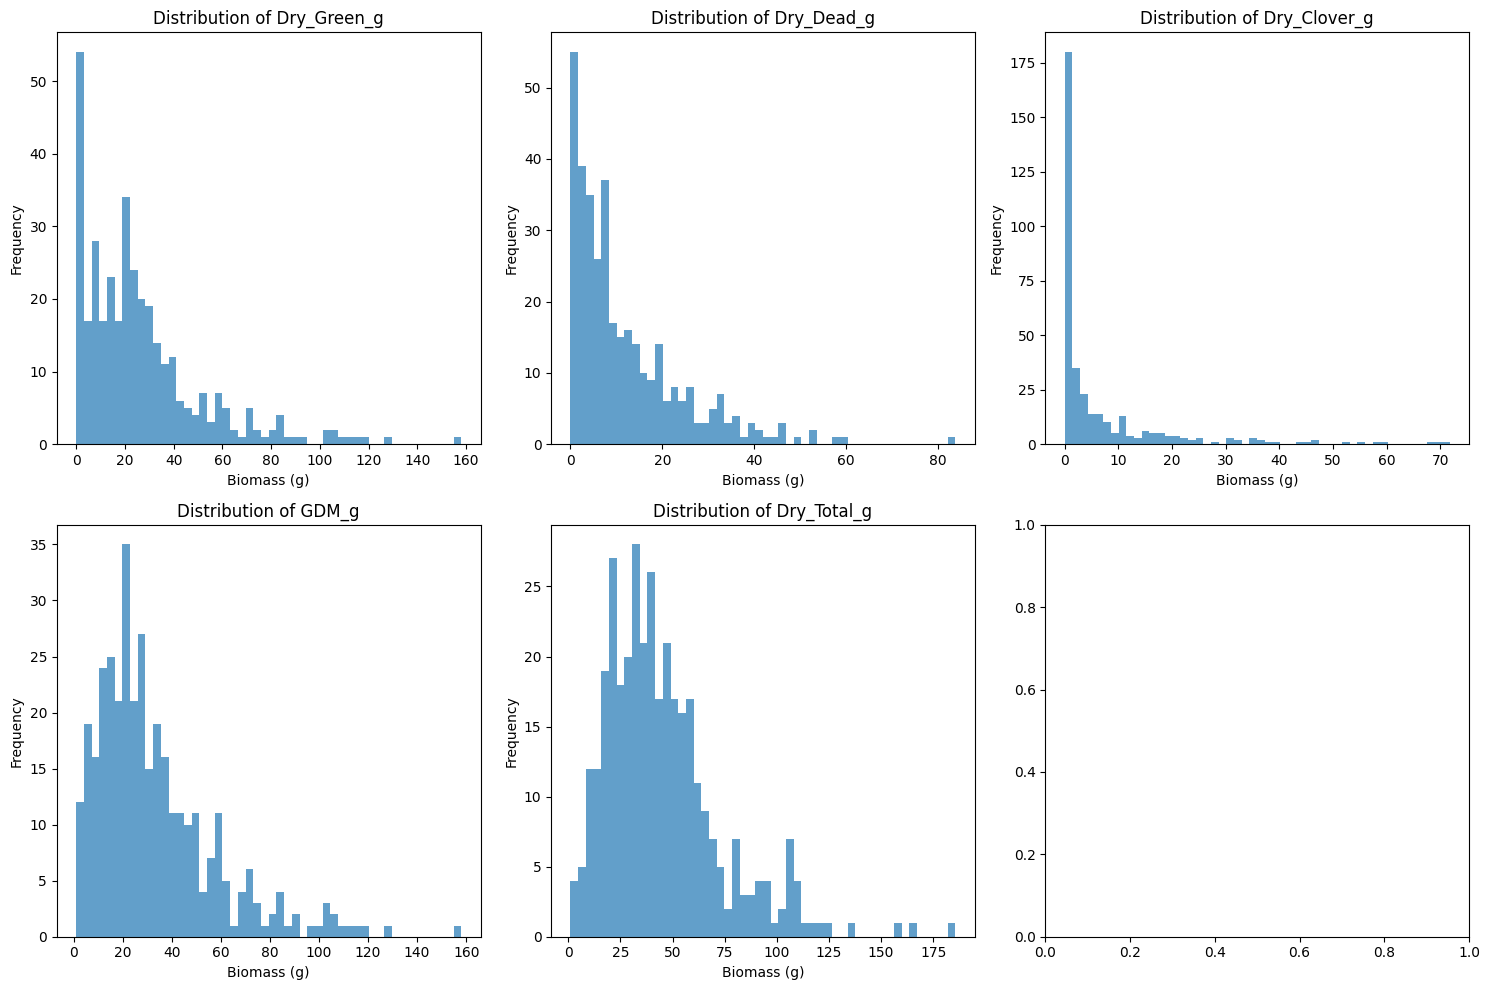

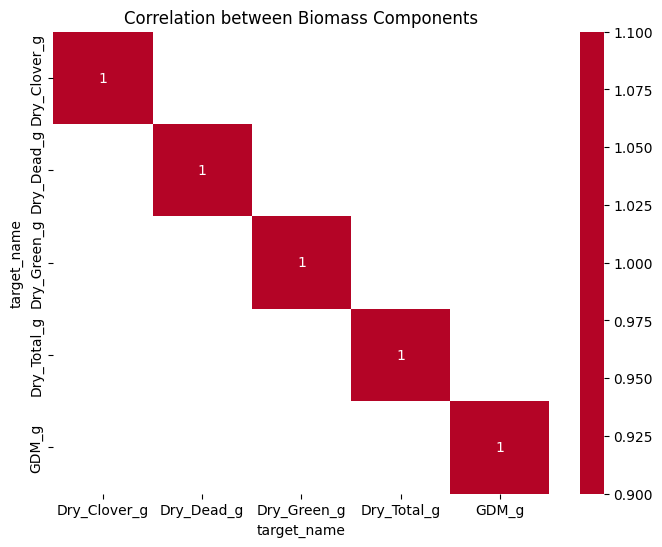

In [ ]:
#1. Data Loading and Exploration
from pathlib import Path
class PastureDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, is_test=False):
        """
        Dataset for pasture biomass prediction

        Args:
            csv_file: Path to csv file
            image_dir: Directory with images
            transform: Image transformations
            is_test: Whether this is test data
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test
        # For training data, we need to handle multiple targets per image
        if not is_test:
            self.image_targets = self._prepare_training_data()

    def _prepare_training_data(self):
        """Group targets by image for training"""
        image_groups = self.data.groupby('image_path')
        image_targets = {}

        for image_path, group in image_groups:
            targets = {}
            for _, row in group.iterrows():
                targets[row['target_name']] = row['target']
            image_targets[image_path] = targets

        return image_targets

    def __len__(self):
        if self.is_test:
            return len(self.data)
        else:
            return len(self.image_targets)

    def __getitem__(self, idx):
        if self.is_test:
            sample = self.data.iloc[idx]
            image_path = sample['image_path']  # already absolute
            img = Image.open(image_path).convert('RGB')
            if self.transform:
                img = self.transform(img)

            return {
                'image': img,
                'target_name': sample['target_name'],
                'sample_id': sample['sample_id'],
                'image_path': image_path
            }
        else:
            image_path = list(self.image_targets.keys())[idx]
            targets_dict = self.image_targets[image_path]

            img = Image.open(image_path).convert('RGB')  # already absolute
            if self.transform:
                img = self.transform(img)

            target_order = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
            targets = [targets_dict.get(name, 0.0) for name in target_order]
            targets = torch.FloatTensor(targets)

            return {
                'image': img,
                'targets': targets,
                'image_path': image_path
            }


def explore_data():
    """Explore the training data distribution"""
    train_df = pd.read_csv("/content/drive/MyDrive/csiro/csiro-biomass/train.csv")

    print("Training data shape:", train_df.shape)
    print("\nTarget value distribution:")
    print(train_df.groupby('target_name')['target'].describe())

    # Plot target distributions
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    targets = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

    for i, target in enumerate(targets):
        target_data = train_df[train_df['target_name'] == target]['target']
        axes[i].hist(target_data, bins=50, alpha=0.7)
        axes[i].set_title(f'Distribution of {target}')
        axes[i].set_xlabel('Biomass (g)')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Check for correlations between targets
    pivot_df = train_df.pivot_table(index='sample_id', columns='target_name', values='target')
    correlation_matrix = pivot_df.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Biomass Components')
    plt.show()

# Explore the data
explore_data()

In [ ]:
class PastureDataset(Dataset):
    def __init__(self, df, transform=None, target_mean=None, target_std=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
        self.target_mean = target_mean
        self.target_std = target_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        targets = row[self.target_cols].values.astype(np.float32)
        if self.target_mean is not None:
            targets = (targets - self.target_mean) / self.target_std

        return {
            "image": image,
            "targets": torch.tensor(targets, dtype=torch.float32)
        }


In [ ]:
# vit-Base/16
import timm
import torch
import torch.nn as nn

class PastureBiomassModel(nn.Module):
    def __init__(self, num_targets=5, pretrained=True):
        super(PastureBiomassModel, self).__init__()

        # -----------------------------
        # ViT-Base/16 backbone (384x384)
        # -----------------------------
        self.backbone = timm.create_model(
            "vit_base_patch16_384",
            pretrained=pretrained,
            num_classes=0   # remove classifier, output features only
        )

        in_features = self.backbone.num_features  # 768 for ViT-B/16

        # Shared MLP head
        self.shared_features = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Multi-target regression heads
        self.heads = nn.ModuleList([
            nn.Linear(256, 1) for _ in range(num_targets)
        ])

        self.target_names = [
            'Dry_Green_g',
            'Dry_Dead_g',
            'Dry_Clover_g',
            'GDM_g',
            'Dry_Total_g'
        ]

    def forward(self, x, target_name=None):
        features = self.backbone(x)  # (B, 768)
        shared_out = self.shared_features(features)

        if target_name is not None:
            # Inference for a specific target
            target_idx = self.target_names.index(target_name)
            output = self.heads[target_idx](shared_out)
            return output
        else:
            # Training: predict all 5 targets
            outputs = [head(shared_out) for head in self.heads]
            return torch.cat(outputs, dim=1)


In [ ]:
class MultiTargetMSELoss(nn.Module):
    def __init__(self):
        super(MultiTargetMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        # predictions: (B, 5)
        # targets: (B, 5)
        loss = 0
        for i in range(targets.shape[1]):
            loss += self.mse(predictions[:, i], targets[:, i])
        return loss / targets.shape[1]


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Ensure your PastureBiomassModel (ViT-Base/16 backbone) is defined elsewhere and imported here


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_model():
    # -----------------------------
    # 1. Data transformations (ViT normalization)
    # -----------------------------
    train_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # -----------------------------
    # 2. Load CSV, pivot to wide format, clean, compute stats
    # -----------------------------
    df = pd.read_csv("/content/drive/MyDrive/csiro/csiro-biomass/train.csv")

    # Pivot to wide: one row per image_path, 5 target columns
    df_wide = df.pivot_table(
        index=["sample_id", "image_path"],
        columns="target_name",
        values="target"
    ).reset_index()
    df_wide.columns.name = None

    target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

    # Fill missing targets with 0 (or use dropna if you prefer)
    df_wide[target_cols] = df_wide[target_cols].fillna(0)

    # Basic sanity check: ensure no NaNs remain
    if df_wide[target_cols].isna().sum().sum() > 0:
        df_wide[target_cols] = df_wide[target_cols].fillna(0)

    # Compute mean/std on wide targets
    target_mean = df_wide[target_cols].mean().values.astype(np.float32)
    target_std = df_wide[target_cols].std(ddof=0).values.astype(np.float32)
    target_std = np.where(target_std < 1e-6, 1e-6, target_std)  # robust epsilon

    print("Target mean:", target_mean)
    print("Target std:", target_std)

    # -----------------------------
    # 3. Dataset and loaders
    # -----------------------------
    full_dataset = PastureDataset(
        df_wide,
        transform=train_transform,
        target_mean=target_mean,
        target_std=target_std
    )

    train_size = int(0.60 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    # apply val transform
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    # -----------------------------
    # 4. Model, loss, optimizer, scheduler
    # -----------------------------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PastureBiomassModel(num_targets=5).to(device)

    criterion = nn.SmoothL1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)  # lowered LR for stability
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # -----------------------------
    # 5. Training loop with gradient clipping and NaN guards
    # -----------------------------
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    num_epochs = 25

    for epoch in range(num_epochs):
        print('epoch #', epoch)
        model.train()
        train_loss = 0.0

        for step, batch in enumerate(train_loader, 1):
            images = batch['image'].to(device, non_blocking=True)
            targets = batch['targets'].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, targets)

            if torch.isnan(loss):
                print(f"NaN loss at step {step}, skipping batch")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        # End of epoch training metrics
        train_loss /= max(1, len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device, non_blocking=True)
                targets = batch['targets'].to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, targets)

                if torch.isnan(loss):
                    print("NaN detected in validation loss, skipping batch")
                    continue

                val_loss += loss.item()

        val_loss /= max(1, len(val_loader))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}]: Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss and not np.isnan(val_loss):
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_pasture_model.pth')
            print("Saved best_pasture_model.pth")

    # -----------------------------
    # 6. Plot training history
    # -----------------------------
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.savefig('training_history.png')
    plt.show()

    return model


# -----------------------------
# 7. Run training
# -----------------------------
if __name__ == "__main__":
    model = train_model()
    torch.save(model.state_dict(), f"/content/drive/MyDrive/csiro/vitbase_25epochs.pth")



Target mean: [5.3249445 2.4089096 1.3299384 6.654883  9.06362  ]
Target std: [15.559666  7.340788  6.029984 17.353977 22.0177  ]


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

epoch # 0
Epoch [1/25], Train Loss: 0.2521
Epoch [1/25]: Val Loss: 0.2594
Saved best_pasture_model.pth
epoch # 1


In [ ]:
#2. Multi-Target Regression Model
class PastureBiomassModel(nn.Module):
    def __init__(self, num_targets=5, pretrained=True):
        super(PastureBiomassModel, self).__init__()

        # Use EfficientNet as backbone
        '''self.backbone = models.efficientnet_b0(pretrained=pretrained)

        # Replace classifier
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()  # Remove original classifier'''
        self.backbone = models.resnet50(pretrained=pretrained)
        # Replace final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove original head

        # Multi-target regression heads
        self.shared_features = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Individual heads for each target
        self.heads = nn.ModuleList([
            nn.Linear(256, 1) for _ in range(num_targets)
        ])

        self.target_names = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

    def forward(self, x, target_name=None):
        features = self.backbone(x)
        shared_out = self.shared_features(features)

        if target_name is not None:
            # For test time - specific target
            target_idx = self.target_names.index(target_name)
            output = self.heads[target_idx](shared_out)
            return output
        else:
            # For training - all targets
            outputs = [head(shared_out) for head in self.heads]
            return torch.cat(outputs, dim=1)

class MultiTargetMSELoss(nn.Module):
    def __init__(self):
        super(MultiTargetMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        # Calculate MSE for each target and average
        loss = 0
        for i in range(targets.shape[1]):
            loss += self.mse(predictions[:, i], targets[:, i])
        return loss / targets.shape[1]

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Ensure your PastureBiomassModel (ViT-Base/16 backbone) is defined/imported


# -----------------------------
# Dataset (expects a wide DataFrame)
# -----------------------------
class PastureDataset(Dataset):
    def __init__(self, df, transform=None, target_mean=None, target_std=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
        self.target_mean = target_mean
        self.target_std = target_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        targets = row[self.target_cols].values.astype(np.float32)
        # standardize targets
        if self.target_mean is not None and self.target_std is not None:
            targets = (targets - self.target_mean) / self.target_std

        return {
            "image": image,
            "targets": torch.tensor(targets, dtype=torch.float32)
        }


def train_model():
    # -----------------------------
    # 1. Data transformations (ViT normalization)
    # -----------------------------
    train_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # -----------------------------
    # 2. Load CSV, pivot to wide format, clean, compute stats
    # -----------------------------
    df = pd.read_csv("/content/drive/MyDrive/csiro/csiro-biomass/train.csv")

    df_wide = df.pivot_table(
        index=["sample_id", "image_path"],
        columns="target_name",
        values="target"
    ).reset_index()
    df_wide.columns.name = None

    target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
    df_wide[target_cols] = df_wide[target_cols].fillna(0)

    target_mean = df_wide[target_cols].mean().values.astype(np.float32)
    target_std = df_wide[target_cols].std(ddof=0).values.astype(np.float32)
    target_std = np.where(target_std < 1e-6, 1e-6, target_std)

    print("Target mean:", target_mean)
    print("Target std:", target_std)

    # -----------------------------
    # 3. Dataset and loaders
    # -----------------------------
    full_dataset = PastureDataset(
        df_wide,
        transform=train_transform,
        target_mean=target_mean,
        target_std=target_std
    )

    train_size = int(0.60 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    # apply val transform
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    # -----------------------------
    # 4. Model, loss, optimizer, scheduler
    # -----------------------------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PastureBiomassModel(num_targets=5).to(device)

    criterion = nn.SmoothL1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # -----------------------------
    # 5. Training loop with gradient clipping and unified validation+R²
    # -----------------------------
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    num_epochs = 25

    for epoch in range(num_epochs):
        print('epoch #', epoch)
        model.train()
        train_loss = 0.0

        for step, batch in enumerate(train_loader, 1):
            images = batch['image'].to(device, non_blocking=True)
            targets = batch['targets'].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, targets)

            if torch.isnan(loss):
                print(f"NaN loss at step {step}, skipping batch")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= max(1, len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

        # -------- Validation (loss + R² in one pass) --------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device, non_blocking=True)
                targets = batch['targets'].to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, targets)
                if torch.isnan(loss):
                    print("NaN detected in validation loss, skipping batch")
                    continue

                val_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

        val_loss /= max(1, len(val_loader))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute R² (de-standardized)
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        all_preds = all_preds * target_std + target_mean
        all_targets = all_targets * target_std + target_mean

        r2_scores = []
        for i, col in enumerate(target_cols):
            r2_scores.append(r2_score(all_targets[:, i], all_preds[:, i]))
        mean_r2 = float(np.mean(r2_scores))

        print(f"Epoch [{epoch+1}/{num_epochs}]: Val Loss: {val_loss:.4f}, Mean R²: {mean_r2:.4f}")
        print("Per-target R²:", {col: round(r, 3) for col, r in zip(target_cols, r2_scores)})

        # Step scheduler and save best
        scheduler.step(val_loss)
        if val_loss < best_val_loss and not np.isnan(val_loss):
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_pasture_model.pth')
            print("Saved best_pasture_model.pth")

    # -----------------------------
    # 6. Plot training history
    # -----------------------------
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.savefig('training_history.png')
    plt.show()

    return model


# -----------------------------
# 7. Run training
# -----------------------------
if __name__ == "__main__":
    model = train_model()
    torch.save(model.state_dict(), f"/content/drive/MyDrive/csiro/vitbase_25epochs.pth")





Target mean: [5.3249445 2.4089096 1.3299384 6.654883  9.06362  ]
Target std: [15.559666  7.340788  6.029984 17.353977 22.0177  ]
epoch # 0
Epoch [1/25], Train Loss: 0.2510
Epoch [1/25]: Val Loss: 0.2407
Saved best_pasture_model.pth
epoch # 1
Epoch [2/25], Train Loss: 0.2488
Epoch [2/25]: Val Loss: 0.2418
epoch # 2
Epoch [3/25], Train Loss: 0.2487
Epoch [3/25]: Val Loss: 0.2392
Saved best_pasture_model.pth
epoch # 3
Epoch [4/25], Train Loss: 0.2484
Epoch [4/25]: Val Loss: 0.2389
Saved best_pasture_model.pth
epoch # 4
Epoch [5/25], Train Loss: 0.2482
Epoch [5/25]: Val Loss: 0.2445
epoch # 5
Epoch [6/25], Train Loss: 0.2480
Epoch [6/25]: Val Loss: 0.2420
epoch # 6
Epoch [7/25], Train Loss: 0.2475
Epoch [7/25]: Val Loss: 0.2540
epoch # 7
Epoch [8/25], Train Loss: 0.2473
Epoch [8/25]: Val Loss: 0.2426
epoch # 8
Epoch [9/25], Train Loss: 0.2458
Epoch [9/25]: Val Loss: 0.2440
epoch # 9
Epoch [10/25], Train Loss: 0.2458
Epoch [10/25]: Val Loss: 0.2515
epoch # 10
Epoch [11/25], Train Loss: 0.24

In [ ]:
#4. Prediction and Submission
def create_submission():
    """Create submission file for test data"""

    # Load test data
    test_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/test.csv')
    submission_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/sample_submission.csv')

    # Load trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PastureBiomassModel(num_targets=5)
    model.load_state_dict(torch.load('best_pasture_model.pth', map_location=device))
    model.to(device)
    model.eval()

    # Test transformations
    test_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = PastureDataset(
        "/content/drive/MyDrive/csiro/csiro-biomass/test.csv",
        image_dir=None)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    predictions = {}

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            target_names = batch['target_name']
            sample_ids = batch['sample_id']

            for i, (sample_id, target_name) in enumerate(zip(sample_ids, target_names)):
                # Get prediction for specific target
                output = model(images[i].unsqueeze(0), target_name)
                prediction = output.item()

                # Ensure non-negative predictions
                prediction = max(0, prediction)
                predictions[sample_id] = prediction

    # Create submission
    submission_df['target'] = submission_df['sample_id'].map(predictions)

    # Fill any missing values with median from training data
    train_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/train.csv')
    target_medians = train_df.groupby('target_name')['target'].median()

    for sample_id in submission_df[submission_df['target'].isna()]['sample_id']:
        target_name = test_df[test_df['sample_id'] == sample_id]['target_name'].iloc[0]
        submission_df.loc[submission_df['sample_id'] == sample_id, 'target'] = target_medians[target_name]

    # Save submission
    submission_df.to_csv('/content/drive/MyDrive/csiro/submission.csv', index=False)
    print("Submission file created: submission.csv")

    # Show prediction statistics
    print("\nPrediction Statistics:")
    print(submission_df['target'].describe())

    return submission_df

# Create submission

submission = create_submission()

In [ ]:
#replacement of the above PastureData
from pathlib import Path
from torch.utils.data import Dataset
import pandas as pd
import torch
from PIL import Image
import numpy as np

class PastureDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, is_test=False, apply_log=True):
        """
        Dataset for pasture biomass prediction.

        Args:
            csv_file: Path to csv file
            image_dir: Directory with images
            transform: Image transformations
            is_test: Whether this is test data
            apply_log: Apply log1p transform to targets (recommended)
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test
        self.apply_log = apply_log

        # For training data, group all targets belonging to the same image
        if not is_test:
            self.image_targets = self._prepare_training_data()

        # Fixed target order required by the model
        self.target_order = [
            'Dry_Green_g',
            'Dry_Dead_g',
            'Dry_Clover_g',
            'GDM_g',
            'Dry_Total_g'
        ]

    def _prepare_training_data(self):
        """Group targets by image for training"""
        image_groups = self.data.groupby('image_path')
        image_targets = {}

        for image_path, group in image_groups:
            targets = {}
            for _, row in group.iterrows():
                targets[row['target_name']] = row['target']
            image_targets[image_path] = targets

        return image_targets

    def __len__(self):
        return len(self.data) if self.is_test else len(self.image_targets)

    def __getitem__(self, idx):
        if self.is_test:
            # Test mode: return image + metadata only
            sample = self.data.iloc[idx]
            image_path = sample['image_path']
            img = Image.open(image_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return {
                'image': img,
                'target_name': sample['target_name'],
                'sample_id': sample['sample_id'],
                'image_path': image_path
            }

        # Training mode
        image_path = list(self.image_targets.keys())[idx]
        targets_dict = self.image_targets[image_path]

        # Load image
        img = Image.open(image_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        # Extract targets in correct order
        targets = np.array([targets_dict.get(name, 0.0) for name in self.target_order], dtype=float)

        # ✅ Apply log1p transform (recommended for regression stability)
        if self.apply_log:
            targets = np.log1p(targets)

        targets = torch.FloatTensor(targets)

        return {
            'image': img,
            'targets': targets,
            'image_path': image_path
        }



In [ ]:
def create_submission():
    """Create submission file for test data"""

    # Load test data
    test_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/test.csv')
    submission_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/sample_submission.csv')

    # Load trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PastureBiomassModel(num_targets=5)
    model.load_state_dict(torch.load('best_pasture_model.pth', map_location=device))
    model.to(device)
    model.eval()

    # Test transformations
    test_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # ✅ Correct dataset instantiation
    test_dataset = PastureDataset(
        "/content/drive/MyDrive/csiro/csiro-biomass/test.csv",
        image_dir=None,
        transform=test_transform,
        is_test=True
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    predictions = {}

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            target_names = batch['target_name']
            sample_ids = batch['sample_id']

            for i, (sample_id, target_name) in enumerate(zip(sample_ids, target_names)):
                output = model(images[i].unsqueeze(0), target_name)
                prediction = max(0, output.item())  # ensure non-negative
                predictions[sample_id] = prediction

    # Create submission
    submission_df['target'] = submission_df['sample_id'].map(predictions)

    # Fill missing values with medians
    train_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/train.csv')
    target_medians = train_df.groupby('target_name')['target'].median()

    for sample_id in submission_df[submission_df['target'].isna()]['sample_id']:
        target_name = test_df[test_df['sample_id'] == sample_id]['target_name'].iloc[0]
        submission_df.loc[submission_df['sample_id'] == sample_id, 'target'] = target_medians[target_name]

    # Save submission
    submission_df.to_csv('/content/drive/MyDrive/csiro/submission.csv', index=False)
    print("Submission file created: submission.csv")

    print("\nPrediction Statistics:")
    print(submission_df['target'].describe())

    return submission_df

submission = create_submission()


In [ ]:
class MultiTargetWrapper(nn.Module):
    def __init__(self, backbone, in_features, num_targets=5):
        super().__init__()
        self.backbone = backbone
        self.shared_features = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # Each head predicts a continuous biomass weight
        self.heads = nn.ModuleList([nn.Linear(512, 1) for _ in range(num_targets)])

    def forward(self, x):
        x = self.backbone(x)
        if x.dim() > 2:
            x = torch.flatten(x, 1)
        shared = self.shared_features(x)
        outputs = [head(shared) for head in self.heads]
        return torch.cat(outputs, dim=1)  # shape: (batch, num_targets)


In [ ]:
'''import torch
import torch.nn as nn
import torchvision.models as models
model_paths = {
    'mobilenet_v2': "/content/drive/MyDrive/csiro/mobilenet_v2.pth",
    'googlenet': "/content/drive/MyDrive/csiro/googlenet.pth",
    'alexnet': "/content/drive/MyDrive/csiro/alexnet.pth",
    'resnet50': "/content/drive/MyDrive/csiro/resnet50.pth",
    'convnext_tiny': "/content/drive/MyDrive/csiro/convnext_tiny.pth",
    'efficientnet_b0': "/content/drive/MyDrive/csiro/efficientnet_b0.pth"
}


def build_model(arch, num_targets=5, load_weights=False, device='cpu'):
    if arch == 'mobilenet_v2':

        backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

        # ✅ Extract correct feature size (1280)
        in_features = backbone.classifier[1].in_features

        # ✅ Remove classifier
        backbone.classifier = nn.Identity()
    elif arch == 'googlenet':
        backbone = models.googlenet(weights=None, aux_logits=False)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
    elif arch == 'alexnet':
        backbone = models.alexnet(weights=None)
        # Flatten the conv output (256*6*6 = 9216)
        in_features = 9216
        backbone.classifier = nn.Sequential(
            nn.Flatten()
        )
    elif arch == 'resnet50':
        backbone = models.resnet50(weights=None)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
    elif arch == "convnext_tiny":
        backbone = models.convnext_tiny(weights=None)
        in_features = backbone.classifier[2].in_features
        backbone.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )
    elif arch == 'efficientnet_b0':
        backbone = models.efficientnet_b0(weights=None)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    model = MultiTargetWrapper(backbone, in_features, num_targets=5)

    if load_weights:
        path = model_paths.get(arch)
        if path:
            state = torch.load(path, map_location=device)
            model.load_state_dict(state, strict=True)
        else:
            raise FileNotFoundError(f"No path found for architecture: {arch}")

    return model'''


In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git


In [ ]:
!pip install ultralytics


In [ ]:
class CNN_LSTM_BiomassEstimator(nn.Module):
    def __init__(self, backbone, feature_dim, hidden_dim=256, num_layers=1, num_targets=1):
        super().__init__()
        self.backbone = backbone

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        # Regression head for biomass
        self.fc = nn.Linear(hidden_dim, num_targets)

    def forward(self, x):
        """
        Accepts:
            (B, C, H, W)  -> single image
            (B, T, C, H, W) -> sequence of images
        """

        # 🔥 Automatically convert single images into a sequence of length 1
        if x.dim() == 4:
            x = x.unsqueeze(1)   # (B, 1, C, H, W)

        # Now safe to unpack
        b, t, c, h, w = x.shape

        # Merge batch + time for CNN
        x = x.view(b * t, c, h, w)

        # Extract CNN features
        feats = self.backbone(x)  # (b*t, feature_dim)

        # Restore sequence structure
        feats = feats.view(b, t, -1)

        # LSTM
        lstm_out, _ = self.lstm(feats)

        # Predict using last timestep
        out = self.fc(lstm_out[:, -1, :])
        return out



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
# from ultralytics import YOLO   # uncomment if using YOLO

model_paths = {
    'mobilenet_v2': "/content/drive/MyDrive/csiro/mobilenet_v2.pth",
    'googlenet': "/content/drive/MyDrive/csiro/googlenet.pth",
    'alexnet': "/content/drive/MyDrive/csiro/alexnet.pth",
    'resnet50': "/content/drive/MyDrive/csiro/resnet50.pth",
    'convnext_tiny': "/content/drive/MyDrive/csiro/convnext_tiny.pth",
    'efficientnet_b0': "/content/drive/MyDrive/csiro/efficientnet_b0.pth",
    'yolov11': "/content/drive/MyDrive/csiro/yolov11.pt",
    'yolov12': "/content/drive/MyDrive/csiro/yolov12.pt"
}

def build_model(
    arch,
    num_targets=5,
    use_lstm=False,
    hidden_dim=256,
    num_layers=1,
    load_weights=False,
    device='cpu'
):
    # -----------------------------
    # CNN BACKBONES
    # -----------------------------
    if arch == 'mobilenet_v2':
        backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        if use_lstm:
            return CNN_LSTM_BiomassEstimator(
                backbone=backbone,              # ✅ use backbone directly
                feature_dim=in_features,        # ✅ use in_features
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                num_targets=num_targets
            )

    elif arch == 'googlenet':
        backbone = models.googlenet(weights=None, aux_logits=False)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

    elif arch == 'alexnet':
        backbone = models.alexnet(weights=None)
        in_features = 9216
        backbone.classifier = nn.Sequential(nn.Flatten())

    elif arch == 'resnet50':
        backbone = models.resnet50(weights=None)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

    elif arch == "convnext_tiny":
        backbone = models.convnext_tiny(weights=None)
        in_features = backbone.classifier[2].in_features
        backbone.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )

    elif arch == 'efficientnet_b0':
        backbone = models.efficientnet_b0(weights=None)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()

    # -----------------------------
    # YOLO MODELS
    # -----------------------------
    elif arch in ['yolov11', 'yolov12']:
        if load_weights:
            model = YOLO(model_paths[arch])
        else:
            model = YOLO(f"{arch}.yaml")

        # YOLO backbone feature dimension (example: 1024)
        feature_dim = 1024  # adjust based on YOLO version

        if use_lstm:
            return CNN_LSTM_BiomassEstimator(
                backbone=model.model.backbone,
                feature_dim=feature_dim,
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                num_targets=num_targets
            )
        else:
            return model

    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    # -----------------------------
    # APPLY LSTM OR STANDARD HEAD
    # -----------------------------
    if use_lstm:
        model = CNN_LSTM_BiomassEstimator(
            backbone=backbone,
            feature_dim=in_features,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_targets=num_targets
        )
    else:
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)

    # -----------------------------
    # LOAD WEIGHTS IF REQUESTED
    # -----------------------------
    if load_weights and arch not in ['yolov11', 'yolov12']:
        state = torch.load(model_paths[arch], map_location=device)
        model.load_state_dict(state, strict=True)

    return model


In [ ]:
# modified the above to include yolos
import torch
import torch.nn as nn
import torchvision.models as models
#from ultralytics import YOLO   # for YOLOv8, v9, v11, v12 and above

model_paths = {
    'mobilenet_v2': "/content/drive/MyDrive/csiro/mobilenet_v2.pth",
    'googlenet': "/content/drive/MyDrive/csiro/googlenet.pth",
    'alexnet': "/content/drive/MyDrive/csiro/alexnet.pth",
    'resnet50': "/content/drive/MyDrive/csiro/resnet50.pth",
    'convnext_tiny': "/content/drive/MyDrive/csiro/convnext_tiny.pth",
    'efficientnet_b0': "/content/drive/MyDrive/csiro/efficientnet_b0.pth",
    'yolov11': "/content/drive/MyDrive/csiro/yolov11.pt",
    'yolov12': "/content/drive/MyDrive/csiro/yolov12.pt"
}


def build_model1(arch, num_targets=5, load_weights=False, device='cpu'):
    if arch == 'mobilenet_v2':
        backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)
    else:
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)


    elif arch == 'googlenet':
        backbone = models.googlenet(weights=None, aux_logits=False)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)

    elif arch == 'alexnet':
        backbone = models.alexnet(weights=None)
        in_features = 9216
        backbone.classifier = nn.Sequential(nn.Flatten())
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)

    elif arch == 'resnet50':
        backbone = models.resnet50(weights=None)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)

    elif arch == "convnext_tiny":
        backbone = models.convnext_tiny(weights=None)
        in_features = backbone.classifier[2].in_features
        backbone.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)

    elif arch == 'efficientnet_b0':
        backbone = models.efficientnet_b0(weights=None)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        model = MultiTargetWrapper(backbone, in_features, num_targets=num_targets)

    elif arch in ['yolov11', 'yolov12']:
        # YOLO models are detection networks, not classification backbones
        if load_weights:
            path = model_paths.get(arch)
            if path:
                model = YOLO(path)  # load pretrained weights
            else:
                raise FileNotFoundError(f"No path found for architecture: {arch}")
        else:
            # Train from scratch using YAML config
            model = YOLO(f"{arch}.yaml")

    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    if load_weights and arch not in ['yolov11', 'yolov12']:
        path = model_paths.get(arch)
        if path:
            state = torch.load(path, map_location=device)
            model.load_state_dict(state, strict=True)
        else:
            raise FileNotFoundError(f"No path found for architecture: {arch}")

    return model


In [ ]:
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("/content/drive/MyDrive/csiro/csiro-biomass/test.csv")

# Pivot so each image has one row with 5 targets
wide_df = df.pivot(index="image_path", columns="target_name", values="sample_id")

# If you have actual numeric biomass values in another column (say "value"),
# replace `sample_id` with that column instead.
# Example:
# wide_df = df.pivot(index="image_path", columns="target_name", values="value")

wide_df.reset_index(inplace=True)
print(wide_df.head())


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Test transformations

class PastureDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        self.image_paths = df["image_path"].unique()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # only the image

def predict_model(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []

    with torch.no_grad():
        for batch in test_loader:   # batch is a dict
            images = batch.to(device)
            outputs = model(images)
            preds.extend(outputs.cpu().numpy())

    return preds


results = {}
test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Correct dataset instantiation
test_dataset = PastureDataset(
    "/content/drive/MyDrive/csiro/csiro-biomass/test.csv",
    transform=test_transform

)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
for arch, path in model_paths.items():
    print(f"\nPredicting with {arch}...")
    model = build_model(arch, num_targets=5, load_weights=True, device=device)
    preds = predict_model(model, test_loader, device)
    results[arch] = preds
df = pd.read_csv("/content/drive/MyDrive/csiro/csiro-biomass/test.csv")
combined = pd.DataFrame({"image_path": df["image_path"].unique()})
for arch, preds in results.items():
    df = pd.DataFrame(preds, columns=[
        f"{arch}_Dry_Clover_g", f"{arch}_Dry_Dead_g",
        f"{arch}_Dry_Green_g", f"{arch}_Dry_Total_g", f"{arch}_GDM_g"
    ])
    combined = pd.concat([combined, df], axis=1)

print(combined.head())



In [ ]:
veg_types = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

records = []
for img_path, pred in zip(test_dataset.image_paths, preds):
    for veg, value in zip(veg_types, pred):
        records.append({"image_path": img_path, "vegetation": veg, "prediction": value})

pred_df = pd.DataFrame(records)


In [ ]:
state = torch.load("/content/drive/MyDrive/csiro/mobilenet_v2.pth", map_location="cpu")
print([k for k in state.keys() if "heads" in k or "shared_features" in k])


In [ ]:
import torch
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Known class names from your CSV
CLASS_NAMES = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)
    mae_sum, mse_sum, n = 0.0, 0.0, 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            targets = batch['targets'].to(device).float()
            outputs = model(images)

            mae_sum += torch.mean(torch.abs(outputs - targets)).item()
            mse_sum += torch.mean((outputs - targets) ** 2).item()
            n += 1

    return {"MAE": mae_sum/n, "RMSE": (mse_sum/n) ** 0.5}

def recover_label_map(model, test_loader, device):
    best_acc = -1.0
    best_mapping = None

    # Try all permutations of indices 0..4 assigned to the class names
    for perm in itertools.permutations(range(len(CLASS_NAMES))):
        candidate = {cls: idx for cls, idx in zip(CLASS_NAMES, perm)}
        acc = evaluate_with_mapping(model, test_loader, candidate, device)
        if acc > best_acc:
            best_acc, best_mapping = acc, candidate

    return best_mapping, best_acc

# Example usage with one architecture (do for the most stable model first)
print("\nRecovering label_map using mobilenet_v2...")
model = build_model('mobilenet_v2', num_targets=5, load_weights=True, device=device)
recovered_map, recovered_acc = recover_label_map(model, test_loader, device)
print("Recovered mapping:", recovered_map)
print(f"Accuracy with recovered mapping: {recovered_acc:.2%}")


In [ ]:
'''import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import transforms
# Image preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((384, 384)),   # resize to match backbone input
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

# Train dataset
train_dataset = PastureDataset(
    csv_file="/content/drive/MyDrive/csiro/csiro-biomass/train.csv",
    image_dir="/content/drive/MyDrive/csiro/csiro-biomass/train",
    transform=train_transforms,
    is_test=False
)

# Test dataset
test_dataset = PastureDataset(
    csv_file="/content/drive/MyDrive/csiro/csiro-biomass/test.csv",
    image_dir="/content/drive/MyDrive/csiro/csiro-biomass/test",
    transform=test_transforms,
    is_test=True
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)'''


In [ ]:
#modified codes of the above
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd

# ---------------------------------------------------------
# 1. Train/Validation Split
# ---------------------------------------------------------
full_df = pd.read_csv("/content/drive/MyDrive/csiro/csiro-biomass/train.csv")

train_df, val_df = train_test_split(full_df, test_size=0.15, random_state=42)

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

# ---------------------------------------------------------
# 2. Image preprocessing (KEEPING 384×384)
# ---------------------------------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((384, 384)),     # ✅ keep original competition size
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((384, 384)),     # ✅ keep original size
    transforms.ToTensor(),
])

# ---------------------------------------------------------
# 3. Datasets (log1p enabled)
# ---------------------------------------------------------
train_dataset = PastureDataset(
    csv_file="train_split.csv",
    image_dir="/content/drive/MyDrive/csiro/csiro-biomass/train",
    transform=train_transforms,
    is_test=False,
    apply_log=True
)

val_dataset = PastureDataset(
    csv_file="val_split.csv",
    image_dir="/content/drive/MyDrive/csiro/csiro-biomass/train",
    transform=test_transforms,
    is_test=False,
    apply_log=True
)

test_dataset = PastureDataset(
    csv_file="/content/drive/MyDrive/csiro/csiro-biomass/test.csv",
    image_dir="/content/drive/MyDrive/csiro/csiro-biomass/test",
    transform=test_transforms,
    is_test=True,
    apply_log=False
)

# ---------------------------------------------------------
# 4. DataLoaders
# ---------------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
def get_backbone_output_dim(backbone):
    dummy = torch.randn(1, 3, 384, 384)   # standard input size
    with torch.no_grad():
        out = backbone(dummy)
        if out.ndim > 2:                  # flatten if conv features
            out = torch.flatten(out, 1)
    return out.shape[1]
def build_model(arch, num_targets=5):
    if arch == 'mobilenet_v2':
        backbone = models.mobilenet_v2(weights=None)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()

    elif arch == 'googlenet':
        backbone = models.googlenet(weights=None, aux_logits=False)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

    elif arch == 'alexnet':
        backbone = models.alexnet(weights=None)
        backbone.classifier = nn.Identity()
        in_features = 9216  # correct feature size
    elif arch == 'resnet50':
        backbone = models.resnet50(weights=None)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()

    elif arch == 'convnext_tiny':
        backbone = models.convnext_tiny(weights=None)
        in_features = backbone.classifier[2].in_features
        backbone.classifier = nn.Identity()

    elif arch == 'efficientnet_b0':
        backbone = models.efficientnet_b0(weights=None)
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
    else:
        raise ValueError(f"Unsupported architecture: {arch}")

    in_features = get_backbone_output_dim(backbone)
    # Shared regression head
    shared_features = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )

    heads = nn.ModuleList([nn.Linear(256, 1) for _ in range(num_targets)])

    return MultiTargetWrapper(backbone, in_features, num_targets=5)



In [ ]:
'''import torch.optim as optim
def eval_r2(model, val_loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            y = batch['targets'].numpy()
            out = model(images).cpu().numpy()
            preds.append(out)
            targets.append(y)
    preds = np.vstack(preds)
    targets = np.vstack(targets)
    return [r2_score(targets[:,i], preds[:,i]) for i in range(5)]


def train_model(model, train_loader, device, num_epochs=10, lr=1e-4):
    #criterion = nn.MSELoss()
    weights = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.5], device=device)
    def weighted_mse(pred, target):
        return ((pred - target)**2 * weights).mean()
    criterion = weighted_mse
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            targets = batch['targets'].to(device).float()  # continuous values

            optimizer.zero_grad()
            outputs = model(images)  # (batch, 5)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, MSE Loss: {avg_loss:.4f}")
    print(eval_r2(model, val_loader, device))
    return model'''




In [ ]:
#modified above codes
import torch.optim as optim
from sklearn.metrics import r2_score

def eval_r2(model, val_loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            y = batch['targets'].numpy()
            out = model(images).cpu().numpy()
            preds.append(out)
            targets.append(y)
    preds = np.vstack(preds)
    targets = np.vstack(targets)
    return [r2_score(targets[:,i], preds[:,i]) for i in range(5)]
def train_model(model, train_loader, val_loader, device, num_epochs=30, lr=7e-8):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            targets = batch['targets'].to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, MSE Loss: {avg_loss:.4f}")

        # ✅ Evaluate R²
        r2 = eval_r2(model, val_loader, device)
        print("Validation R²:", r2)

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

architectures = [
   # 'efficientnet_b0',
   'mobilenet_v2',
   # 'googlenet',
   # 'alexnet',
    #'resnet50',
   # 'convnext_tiny'
]
trained_models = {}

for arch in architectures:
    print(f"\nTraining {arch} from scratch...")
    model = build_model(arch, num_targets=5,use_lstm=True)
    #trained_model = train_model(model, train_loader, device, num_epochs=20, lr=1e-4)
    trained_model = train_model(model, train_loader, val_loader, device, num_epochs=50, lr=5e-7)
    trained_models[arch] = trained_model
    # Save weights
    torch.save(trained_model.state_dict(), f"/content/drive/MyDrive/csiro/{arch}_lstm_50_.pth")


In [ ]:
#resnet50 + LSTM
class ResNetLSTM(nn.Module):
    def __init__(self, num_targets=5, hidden_size=256, num_layers=1, bidirectional=False):
        super().__init__()
        self.backbone = models.resnet50(weights=None)
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        lstm_out_dim = hidden_size * (2 if bidirectional else 1)

        self.head = nn.Sequential(
            nn.Linear(lstm_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_targets)
        )

    def forward(self, x):
        # x: (batch, seq_len, C, H, W)
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        feats = self.backbone(x)         # (b*t, feat_dim)
        if feats.dim() > 2:
            feats = torch.flatten(feats, 1)
        feats = feats.view(b, t, -1)
        lstm_out, _ = self.lstm(feats)
        last_out = lstm_out[:, -1, :]
        out = self.head(last_out)
        return out


In [ ]:
# Mobilenet+LSTM

import torchvision.models as models
import torch
import torch.nn as nn
class MobileNetLSTM(nn.Module):
    def __init__(self, num_targets=5, hidden_size=256, num_layers=1, bidirectional=False):
        super().__init__()
        self.backbone = models.mobilenet_v2(weights=None)   # start from scratch
        feat_dim = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        lstm_out_dim = hidden_size * (2 if bidirectional else 1)

        self.head = nn.Sequential(
            nn.Linear(lstm_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_targets)
        )

    def forward(self, x):
        # Expecting (batch, seq_len, C, H, W)
        if x.dim() == 4:
            # If dataset gives single images, add seq_len=1
            x = x.unsqueeze(1)

        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        feats = self.backbone(x)
        if feats.dim() > 2:
            feats = torch.flatten(feats, 1)

        feats = feats.view(b, t, -1)
        lstm_out, _ = self.lstm(feats)
        last_out = lstm_out[:, -1, :]
        out = self.head(last_out)
        return out


In [ ]:
import torch

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = MobileNetLSTM(num_targets=5, hidden_size=256, num_layers=1, bidirectional=False)

# Train model
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=30, lr=1e-4)

# ---------------------------------------------------------
# Save the trained model
# ---------------------------------------------------------
# Option 1: Save only the state_dict (recommended)
torch.save(trained_model.state_dict(), "mobilenet_lstm_model.pth")

# Option 2: Save the entire model (less portable)
# torch.save(trained_model, "mobilenet_lstm_full.pth")


In [ ]:
#joint MobileNetV2 + ResNet50 model
import torch
import torch.nn as nn
import torchvision.models as models

class DualBackboneMultiTarget(nn.Module):
    def __init__(self, num_targets=5):
        super().__init__()

        # MobileNetV2 backbone
        self.mobilenet = models.mobilenet_v2(weights=None)
        mobilenet_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Identity()

        # ResNet50 backbone
        self.resnet = models.resnet50(weights=None)
        resnet_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # Total fused feature size
        fused_in_features = mobilenet_features + resnet_features

        # Shared MLP (similar to your MultiTargetWrapper)
        self.shared_features = nn.Sequential(
            nn.Linear(fused_in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Multi‑target heads
        self.heads = nn.ModuleList([nn.Linear(256, 1) for _ in range(num_targets)])

    def forward(self, x):
        feat_m = self.mobilenet(x)  # (batch, mobilenet_features)
        feat_r = self.resnet(x)     # (batch, resnet_features)

        # If any is not flattened (should already be), ensure flatten:
        if feat_m.dim() > 2:
            feat_m = torch.flatten(feat_m, 1)
        if feat_r.dim() > 2:
            feat_r = torch.flatten(feat_r, 1)

        fused = torch.cat([feat_m, feat_r], dim=1)  # (batch, fused_in_features)
        shared = self.shared_features(fused)
        outputs = [head(shared) for head in self.heads]
        return torch.cat(outputs, dim=1)  # (batch, num_targets)

# Build and optionally load individual backbone weights
def build_dual_model(mobilenet_path=None, resnet_path=None, device='cpu', num_targets=5):
    model = DualBackboneMultiTarget(num_targets=num_targets)

    # Optional: initialize each backbone with your pre‑trained weights
    if mobilenet_path is not None:
        single_mobilenet = build_model('mobilenet_v2', num_targets=num_targets, load_weights=True, device=device)
        model.mobilenet.load_state_dict(single_mobilenet.backbone.state_dict(), strict=False)

    if resnet_path is not None:
        single_resnet = build_model('resnet50', num_targets=num_targets, load_weights=True, device=device)
        model.resnet.load_state_dict(single_resnet.backbone.state_dict(), strict=False)

    return model

# Example training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dual_model = build_dual_model(
    mobilenet_path="/content/drive/MyDrive/csiro/mobilenet_v2.pth",
    resnet_path="/content/drive/MyDrive/csiro/resnet50.pth",
    device=device,
    num_targets=5
).to(device)

def train_model_regression(model, train_loader, device, num_epochs=10, lr=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            images = batch['image'].to(device)
            targets = batch['targets'].to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, MSE Loss: {avg_loss:.4f}")

    return model

# Train the dual model
dual_model = train_model_regression(dual_model, train_loader, device, num_epochs=30, lr=1e-4)
torch.save(dual_model.state_dict(), "/content/drive/MyDrive/csiro/mobilenet_resnet_dual.pth")


In [ ]:
# Loading models after training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#/content/drive/MyDrive/csiro/efficientnet_b0.pth
architectures = [
    'efficientnet_b0',
    'mobilenet_v2',
    'googlenet',
    'alexnet',
    'resnet50',
    'convnext_tiny'
]
import torch

loaded_models = {}

for arch in architectures:
    print(f"Loading {arch}...")
    model = build_model(arch, num_targets=5)   # must match training setup
    model.load_state_dict(torch.load(f"/content/drive/MyDrive/csiro/{arch}.pth", map_location=device))
    model.to(device)
    model.eval()
    loaded_models[arch] = model


In [ ]:
#to use with testing only
class PastureDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return {
            "image": image,
            "sample_id": row["sample_id"]
        }

In [ ]:
# Testing models after training
import pandas as pd

# Target names in fixed order (must match training order)
target_names = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

def generate_submission(model, test_loader, device, output_csv="submission.csv"):
    model.eval()
    model.to(device)
    predictions = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            outputs = model(images)  # shape (batch, 5)
            outputs = outputs.cpu().numpy()

            # Each row in test.csv has a sample_id like IDxxxx__TargetName
            sample_ids = batch['sample_id']

            for i, sid in enumerate(sample_ids):
                target_name = sid.split("__")[1]
                idx = target_names.index(target_name)

                predictions.append({
                    "sample_id": sid,
                    "target": float(outputs[i, idx])
                })

    df = pd.DataFrame(predictions)
    df.to_csv(output_csv, index=False)
    print(f"Saved predictions to {output_csv}")


In [ ]:
#Looping over all models
# Define transforms
test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and loader
test_dataset = PastureDataset(
    "/content/drive/MyDrive/csiro/csiro-biomass/test.csv",
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Run submission generation
for arch, model in loaded_models.items():
    print(f"Generating submission for {arch}...")
    generate_submission(model, test_loader, device,
                        output_csv=f"/content/drive/MyDrive/csiro/{arch}_submission.csv")



In [ ]:
# Right after you create train_loader
batch = next(iter(train_loader))
print("Sample targets:", batch['targets'][:10])
print("Unique values:", torch.unique(batch['targets']))


In [ ]:
#6. Data Analysis and Feature Engineering
def additional_analysis():
    """Additional data analysis for insights"""

    train_df = pd.read_csv('/content/drive/MyDrive/csiro/csiro-biomass/train.csv')

    # Analyze by state
    plt.figure(figsize=(12, 8))
    for i, target in enumerate(['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g'], 1):
        plt.subplot(2, 3, i)
        target_data = train_df[train_df['target_name'] == target]
        sns.boxplot(data=target_data, x='State', y='target')
        plt.title(f'{target} by State')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Analyze relationship with NDVI and Height
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    targets = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

    for i, target in enumerate(targets):
        target_data = train_df[train_df['target_name'] == target]
        axes[i].scatter(target_data['Pre_GSHH_NDVI'], target_data['target'], alpha=0.5)
        axes[i].set_xlabel('NDVI')
        axes[i].set_ylabel(target)
        axes[i].set_title(f'{target} vs NDVI')

    plt.tight_layout()
    plt.show()

# Run additional analysis
additional_analysis()

In [ ]:
'''Key Features of This Solution:
Multi-Target Architecture: Single model predicting all 5 biomass components

Data Augmentation: Improved generalization with image transformations

Transfer Learning: Using pre-trained EfficientNet backbone

Comprehensive Validation: Proper train/validation split and monitoring

Robust Predictions: Handling edge cases and ensuring non-negative values

Extensible Design: Easy to modify for ensemble approaches

Next Steps for Improvement:
Hyperparameter Tuning: Optimize learning rates, architecture

Ensemble Methods: Combine multiple models

Additional Features: Incorporate NDVI and height data if available

Advanced Augmentation: More sophisticated image transformations

Cross-Validation: More robust validation strategy

This solution provides a solid foundation for predicting pasture biomass components and can be further optimized based on validation performance.'''